# Unzip the data

In [1]:
!unzip 'data.zip'

Archive:  data.zip
  inflating: data/hinglish_stopwords.txt  
   creating: data/test/
  inflating: data/test/Hindi_test_unalbelled_conll_updated.txt  
  inflating: data/test/test_labels_hinglish.txt  
   creating: data/train/
  inflating: data/train/dev_3k_split_conll.txt  
  inflating: data/train/train_14k_split_conll.txt  
  inflating: data/train/train_conll.txt  
  inflating: data/train/trial_conll.txt  


In [2]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 130kB/s 
     |████████████████████████████████| 983kB 53.0MB/s 
     |████████████████████████████████| 266kB 43.9MB/s 
     |████████████████████████████████| 1.3MB 46.3MB/s 
     |████████████████████████████████| 1.1MB 50.4MB/s 
     |████████████████████████████████| 471kB 40.1MB/s 
     |████████████████████████████████| 890kB 49.6MB/s 
     |████████████████████████████████| 2.9MB 48.8MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.2-cp36-none-any.whl size=25276306 sha256=60a60963bd5c3540ba253dc1dee831b0d91c578a213edb1fa5e6464bb50b0494
  Stored in directory: /root/.cache/pip/wheels/fe/56/00/25444c352cc843e5c5daea0e9517a192878ae22c2c6b5f4573
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=84d634a0dd19d4f2128d012a41ff35c419af871b37afb2d8aacab88c70dea56b
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
  Created wheel for syn

# Imports

In [3]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Defining Tweet Class

In [4]:
class Tweet:
    def __init__(self):
        self.uid = None
        self.content = ''
        self.sentiment = ''

# Definining Methods for Data Loading and Cleaning

In [5]:
def cleanTweet(tweet):
#     print(tweet.content,"\n")
#     tweet.content = re.sub(r'@ [0-9a-zA-Z]+', '', tweet.content) # remove @ mentions
    tweet.content = re.sub(r'\_', '', tweet.content) # remove underscores
    tweet.content = re.sub(r'…', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'^RT[\s]+', '', tweet.content) # remove RT
    tweet.content = re.sub("[#@©àâ€¦¥°¤ð¹ÿœ¾¨‡†§‹²¿¸ˆ]", '', tweet.content) # remove weird symbols
    tweet.content = tweet.content.split("http")[0].split('https')[0] # remove http/https
    tweet.content = ''.join([i for i in tweet.content if not i.isdigit()]) # remove digits
    tweet.content = ''.join([word for word in tweet.content if word not in string.punctuation]) # remove punctuations
    tweet.content = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True).tokenize(tweet.content)
    tweet.content = ' '.join([i for i in tweet.content]) # convert to string
#     print(tweet.content)
#     print("============================================================================")
    return tweet

def load_stop_words():
    stopwords_english = stopwords.words('english')
    stopwords_hinglish = []
    with open('data/hinglish_stopwords.txt','r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break
            stopwords_hinglish.append(line.strip())
    return stopwords_english, stopwords_hinglish

def readFile(filename, test_data=False):
    stemmer_english = PorterStemmer()
    stopwords_english, stopwords_hinglish = load_stop_words()
    all_tweets = []
    with open(filename, 'r', encoding="utf8") as fp:
        tweet = Tweet()
        last_one = False
        while True:
            line = fp.readline()
            if not line:
                last_one = True
            if len(line.split()) > 1 or last_one==True:
                if last_one==True or line.split()[0] == 'meta':
                    if len(tweet.content) > 0 or last_one==True:
                        all_tweets.append(cleanTweet(tweet))
                        if last_one==True:
                            break
                        tweet = Tweet()
                    tweet.uid = line.split()[1]
                    tweet.sentiment = line.split()[2] if test_data==False else None
                else:
                    if line.split()[1] == "Eng":
                        if line.split()[0] not in stopwords_english:
#                             line.split()[0] = autoCorrect(line.split()[0])
                            tweet.content += stemmer_english.stem(line.split()[0]) + " "
                    elif line.split()[1] == "Hin":
                        if line.split()[0] not in stopwords_hinglish:
                            tweet.content += line.split()[0] + " "
                    else:
                        tweet.content += line.split()[0] + " "
        return all_tweets

# Defining Method for Showing Results

In [6]:
def plot_confusion_matrix(cm,title='Confusion Matrix',cmap=plt.cm.Greens):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['neutral','positive','negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def show_results(y_test, y_pred):
    print("F1 Score: ", f1_score(y_test, y_pred, average="weighted"))
    print()
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    plot_confusion_matrix(cnf_matrix)

# ===================================================

# Mission Control - Training

### Data Loading

In [7]:
# all_tweets = readFile(r'data\train\train_14k_split_conll.txt')
# all_tweets.extend(readFile(r'data\train\dev_3k_split_conll.txt'))
all_tweets = (readFile(r'data/train/train_conll.txt'))
# all_tweets = (readFile(r'data\train\trial_conll.txt'))

### ktrain Stuff

In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [9]:
import ktrain
from ktrain import text

In [10]:
x_train = [i.content for i in all_tweets]
y_train = [i.sentiment for i in all_tweets]

In [11]:
trn, val, preproc = text.texts_from_array(x_train, y_train, preprocess_mode='bert', maxlen=350, max_features=35000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [12]:
model = text.text_classifier('bert', trn, preproc=preproc)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

Is Multi-Label? False
maxlen is 350
done.


In [ ]:
learner.lr_find(max_epochs=4)

simulating training for different learning rates... this may take a few moments...
Epoch 1/4
2270/2270 [==============================] - 1173s 517ms/step - loss: 1.0216 - accuracy: 0.4560
Epoch 2/4
2270/2270 [==============================] - 1164s 513ms/step - loss: 1.0037 - accuracy: 0.4865
Epoch 3/4
 241/2270 [==>...........................] - ETA: 17:12 - loss: 1.2862 - accuracy: 0.3472

In [ ]:
learner.lr_plot()

In [59]:
learner.fit_onecycle(2e-5, 4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
15/15 [==============================] - 30s 2s/step - loss: 1.1086 - accuracy: 0.3778 - val_loss: 1.0625 - val_accuracy: 0.6000
Epoch 2/4
15/15 [==============================] - 25s 2s/step - loss: 1.0211 - accuracy: 0.4667 - val_loss: 1.0464 - val_accuracy: 0.3000
Epoch 3/4
15/15 [==============================] - 25s 2s/step - loss: 1.0225 - accuracy: 0.5222 - val_loss: 1.1722 - val_accuracy: 0.4000
Epoch 4/4
15/15 [==============================] - 25s 2s/step - loss: 0.7480 - accuracy: 0.7667 - val_loss: 0.9224 - val_accuracy: 0.6000


# ===================================================

# Mission Control - Prediction

### Loading Prediction Data

In [60]:
actual_labels_dict = dict()
with open(r'data/test/test_labels_hinglish.txt','r') as fp:
    line = fp.readline()
    while True:
        line = fp.readline()
        if not line:
            break
        actual_labels_dict[line.strip().split(',')[0]] = line.strip().split(',')[1]
all_test_tweets = readFile(r'data/test/Hindi_test_unalbelled_conll_updated.txt',test_data=True)
for i in all_test_tweets:
    i.sentiment = actual_labels_dict[i.uid]

### Getting the Predictions

In [61]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictions = []
for i in all_test_tweets:
    predictions.append(predictor.predict(i.content))

KeyboardInterrupt: ignored

### The Results

F1 Score:  0.6689286093805984



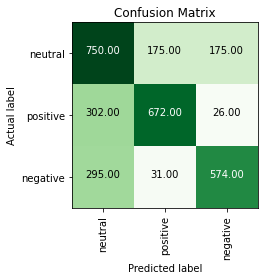

In [ ]:
actual_num = []
for i in all_test_tweets:
    if i.sentiment == "neutral":
        actual_num.append(0)
    elif i.sentiment == "positive":
        actual_num.append(1)
    elif i.sentiment == "negative":
        actual_num.append(2)
predictions_num = []
for i in predictions:
    if i[0][0] == "__label__neutral":
        predictions_num.append(0)
    elif i[0][0] == "__label__positive":
        predictions_num.append(1)
    elif i[0][0] == "__label__negative":
        predictions_num.append(2)

show_results(actual_num, predictions_num)

# Analysing Incorrect Results

In [ ]:
for i in range(len(actual_num)):
    if (actual_num[i]!=predictions_num[i]):
        print("Actual:",all_test_tweets[i].sentiment)
        print("Predicted:",predictions[i][0][0][9:])
        print(all_test_tweets[i].content)
        print("=====================================================================")

Actual: neutral
Predicted: positive
alloo pyaz tomat allah pak naam nazar aa pr aankhon samne allah pak nazar
Actual: neutral
Predicted: positive
sharmakef wer almost final threeday ramadan ” close finish line so let make sure doubl i
Actual: negative
Predicted: neutral
sadifabi shahidmasooddr tm dikha rhy asli auqaat wese btao tou ye propaganda kyu krta shahid masood
Actual: positive
Predicted: neutral
dheeraj nirahua msunilbishnoi wah shandaar jabab
Actual: negative
Predicted: neutral
modi lehar kisano baras kehar tut haath pao road buri halato aasar aajtak bbcbreak
Actual: positive
Predicted: neutral
ravindraj tarekfatah yarr india b life st time india posit dekha appreci u ÿµÿÿ ® ÿ
Actual: positive
Predicted: neutral
baijnathmourya mssirsa aapkamanojs arvindkejriwal haan mai free wifi dunga free water sasti bijli doo
Actual: negative
Predicted: neutral
asifnkhan saumen banerj e jhasanjay time circumst ke change bada bewakuf
Actual: neutral
Predicted: positive
sicilian mafia bhaai e

Actual: neutral
Predicted: positive
om namah shivaya jai shiva shambhu har har mahadev
Actual: negative
Predicted: neutral
kapilmishra ind bhaiya ji tweet credit thora aap cultur dik
Actual: positive
Predicted: neutral
rose k rosi dekna jagah kamal chpa chpa jai shree ram
Actual: positive
Predicted: neutral
pmoindia ram ram suggest rs k upper cash less transact ker jai hind ram ram
Actual: positive
Predicted: neutral
incmp mp congress priyanka mam ji bato pr visvash vijay
Actual: positive
Predicted: neutral
iamvishchauhan accha trade bina saboon dhool saaf
Actual: positive
Predicted: neutral
sineadharnett excit announc girl sing national anthem tonight boy anthonyfjoshua ÿš
Actual: negative
Predicted: neutral
salman khan fan give threat to singer sona mohapatra for insulting bhaijaan
Actual: neutral
Predicted: negative
rakesh beldar iosamol guptavivek arvindkejriwal ye saal nikal
Actual: neutral
Predicted: positive
forshub love danda zombi game
Actual: neutral
Predicted: negative
railw

Actual: neutral
Predicted: negative
savita advrajendrapal aapdelhi aamaadmiparty msisodia manojkjhadu pankajgupta sanjayazadsln drsitu
Actual: neutral
Predicted: positive
modi ji rojgar focu youth strong india strong
Actual: negative
Predicted: positive
btseva america rahai useless koch bi can make happi noor tumaray baap iza
Actual: neutral
Predicted: positive
nakuulmehta dear zindagi many time iv seen walk past you hardli make stop sometim saunter sometim
Actual: positive
Predicted: neutral
antanddec cant wait see boy nation treasur tonight especi ant miss mu
Actual: neutral
Predicted: positive
crankgameplay don ™ mess caus ™ big boy ™ scari you punch wall stay
Actual: neutral
Predicted: negative
azam khan bagal seat sunny deol bc kanhi gaddar ashraf ali ÿ ˜ ÿ ˜ ÿ £ ÿ £
Actual: neutral
Predicted: positive
ye im insan ye im make wangxian stande ye im make version version bg i
Actual: negative
Predicted: neutral
shahid siddiqui kuch dogl beshrm call secul librel gaddaro ankh khuli khul

# ===================================================

### Creating Submission File

In [ ]:
import zipfile
import os

with open('answer.txt',"w") as fp:
    fp.write("Uid,Sentiment\n")
    for i in range(len(predictions_num)):
        if predictions_num[i]==0:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",neutral")
            else:
                fp.write(all_test_tweets[i].uid+",neutral\n")
        elif predictions_num[i]==1:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",positive")
            else:
                fp.write(all_test_tweets[i].uid+",positive\n")                
        elif predictions_num[i]==2:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",negative")
            else:
                fp.write(all_test_tweets[i].uid+",negative\n")

class ZipUtilities:
    def toZip(self, file, filename):
        zip_file = zipfile.ZipFile(filename, 'w')
        if os.path.isfile(file):
            zip_file.write(file)
        else:
            self.addFolderToZip(zip_file, file)
        zip_file.close()

    def addFolderToZip(self, zip_file, folder): 
        for file in os.listdir(folder):
            full_path = os.path.join(folder, file)
            if os.path.isfile(full_path):
                print( 'File added: ' + str(full_path))
                zip_file.write(full_path)
            elif os.path.isdir(full_path):
                print( 'Entering folder: ' + str(full_path))
                self.addFolderToZip(zip_file, full_path)

utilities = ZipUtilities()
filename = 'answer.zip'
directory = 'answer.txt'
utilities.toZip(directory, filename)